# Lab 2 - bandit recommendations

## Lab preparation

 * [optional] Create python virtual enviroment
 `python3 -m venv ./recsyslab2`
 * install libs:
 `pip3 install matplotlib`
 * include `bandit_framework.py` in the same directory

## Część 1. - framework i naiwni bandyci

In [1]:
# import all needed packages

from copy import copy
from math import log, sqrt
from itertools import product
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # test enviroment

In [2]:
# test parameters

runs = 50
epochs = 100
recommendation_size = 10

In [18]:
# initializing arms - payout for each arm(product that can be recommended) will be represented by a constant value (1)
# arms represent CTR, clickthrough rate - probability of click p and constant payout after click
# these arms simulate real products (for example movies) that users can choose
# We'll use them to create bandit simulation - bandits will learn to recommend the good arms

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = {arm.arm_id: arm for arm in good_arms+bad_arms}
arm_ids = list(arms.keys())

In [17]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 6.290088185189246


In [5]:
# random recommendations - useful as a reference model
# we don't want our bandits to be worse than random recommendations

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [6]:
# Perfect bandit - knows how each arm works - it knows the future (probability of clicking on a recommendation)
# useful for comparison with our trained bandits

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # bruteforce search for the expected value
        return sum([payout_function() for i in range(n)]) / n

In [19]:
# list of bandits that we want to compare

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [20]:
# creating a test (Runner class)

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 588.6799999999998
random: 287.02


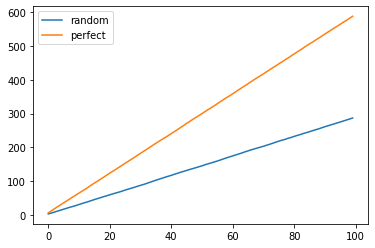

In [9]:
# summary of results for all runner epochs

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 5.92
random: 2.8


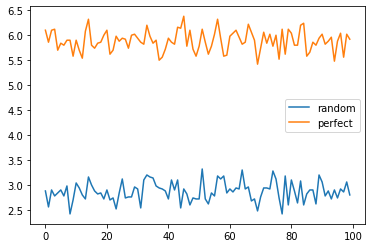

In [10]:
# scores in each epoch

runner.plot_results(results, runs, epochs, mode='average')

## Part 2 - target bandit models

In [11]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        to_recommend = [x[0] for x in sorted(self.payouts_per_recommendation.items(), key=lambda x: x[1], reverse=True)]
        for arm_id in to_recommend: self.recommended_rates[arm_id] += 1
        return to_recommend
        
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

In [12]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        # te zera w mianowniku moga byc problematyczne
        # - zastanow sie, czy lepiej je obslugiwac w locie czy zainicjalizowac te mape wartosciami niezerowymi
        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        self.n = 0
    
    def recommend(self, size):
        raise NotImplementedError()
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]

    def _optimism(self, arm):
        if self.recommended_rates[arm] == 0:
            return 1.0
        return self.optimism_weight * sqrt(log(self.n) / self.recommended_rates[arm])

In [13]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        raise NotImplementedError()
    
    def feedback(self, arm_id, payout):
        reward = payout * self.reward_multiplier
        regret = max(1-payout, 0) * self.regret_multiplier
        self.a[arm_id] += reward
        self.b[arm_id] += regret

## Part 3 - rough bandit comparison

In [14]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [15]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01


NotImplementedError: 

In [ ]:
runner.plot_results(results, runs, epochs, mode='average')

In [ ]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Part 4 - precise bandit comparison

In [ ]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    raise NotImplementedError()

all_relevant = relevant(arms.values())

In [ ]:
# obliczmy precision@k i recall@k (zgodnie ze wzorami z wykladu)
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    raise NotImplementedError()

def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    raise NotImplementedError()

In [ ]:
# sprawdzmy, czy dziala
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

In [ ]:
# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
tesing_bandits = #...
# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10

# dla kazdego bandyty - genetujemy `samples` rekomendacji, liczymy precision i recall, wypisujemy srednie wartosci
# powtarzamy dla kazdego k
raise NotImplementedError()